#### Load Data

In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv("data/exoTrain.csv")
test_data = pd.read_csv("data/exoTest.csv")
train_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


#### Process

In [2]:
# split data into attributes and labels
X_train = train_data.values[:, 1:]
y_train = train_data.values[:, 0] - 1
X_test = test_data.values[:, 1:]
y_test = test_data.values[:, 0] - 1

# standardize
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
# standerdize it on the axis=1, but there isn't parameter `axis`, so I use `transpose` to do that
X_train = ss.fit_transform(X_train.T).T
raw_X_train = X_train.copy()  # backup for visualization at next step
X_test = ss.fit_transform(X_test.T).T

# fourier transformation
from scipy.fftpack import fft, fftshift, fftfreq
X_train = np.abs(fft(X_train))
X_test = np.abs(fft(X_test))
freq_range = fftshift(fftfreq(X_train.shape[1]))

# oversample the neagtive data
from imblearn.over_sampling import SMOTE
model_smote = SMOTE()
X_train, y_train = model_smote.fit_sample(X_train, y_train)

/home/albert/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


#### visualization

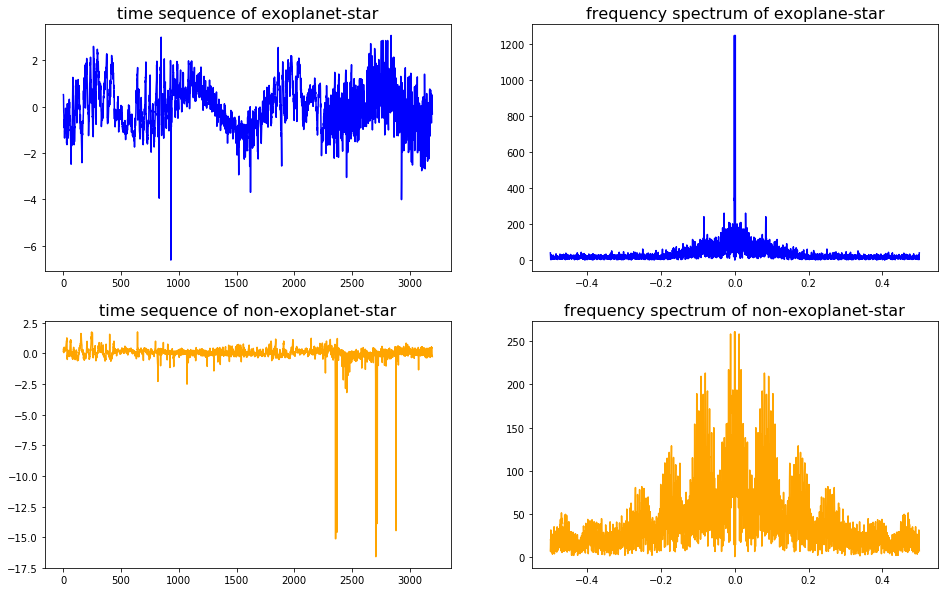

In [3]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(figsize=(16, 10))
ax = plt.subplot(221)
plt.title("time sequence of exoplanet-star", fontsize=16)
plt.plot(raw_X_train[0], "b")
ax = plt.subplot(222)
plt.title("frequency spectrum of exoplane-star", fontsize=16)
plt.plot(freq_range, fftshift(X_train[0]), "b")
ax = plt.subplot(223)
plt.title("time sequence of non-exoplanet-star", fontsize=16)
plt.plot(raw_X_train[100], "orange")
ax = plt.subplot(224)
plt.title("frequency spectrum of non-exoplanet-star", fontsize=16)
plt.plot(freq_range, fftshift(X_train[100]), "orange")
plt.savefig("images/time2freq")
plt.show()

#### PCA

In [4]:
from sklearn.decomposition import PCA
pca = PCA(0.85, True, False)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print("the dimension of decomposed data is ", X_train.shape[1])

the dimension of decomposed data is  101


#### SVM

In [5]:
from sklearn.svm import SVC
from sklearn.externals import joblib
clf = SVC(kernel="linear")
clf.fit(X_train,y_train)
joblib.dump(clf, "model/svm_model.m")

/home/albert/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['svm_model.m']

#### Test

In [7]:
from sklearn import metrics
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("accuracy:", metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       565
         1.0       0.60      0.60      0.60         5

    accuracy                           0.99       570
   macro avg       0.80      0.80      0.80       570
weighted avg       0.99      0.99      0.99       570

accuracy: 0.9929824561403509


#### As we can see, result is good but the recall of explanet is bit low. If the train set is larger the result will be better